In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt



In [5]:
# %%
import os

# Requires dataset folder to be in the same directory as this file, and 
DATA_DIR = './dataset'#r"C:\Users\Korisnik\Downloads\dataset\100k\\"

print(len(os.listdir(DATA_DIR+'/100k')))
print(os.listdir(DATA_DIR+'/100k'))



100000
['000001.jpg', '000002.jpg', '000003.jpg', '000006.jpg', '000008.jpg', '000009.jpg', '000016.jpg', '000017.jpg', '000020.jpg', '000021.jpg', '000022.jpg', '000024.jpg', '000026.jpg', '000028.jpg', '000030.jpg', '000033.jpg', '000035.jpg', '000036.jpg', '000037.jpg', '000039.jpg', '000041.jpg', '000042.jpg', '000044.jpg', '000046.jpg', '000047.jpg', '000050.jpg', '000055.jpg', '000056.jpg', '000057.jpg', '000060.jpg', '000062.jpg', '000064.jpg', '000065.jpg', '000066.jpg', '000067.jpg', '000068.jpg', '000073.jpg', '000075.jpg', '000076.jpg', '000078.jpg', '000079.jpg', '000082.jpg', '000084.jpg', '000085.jpg', '000086.jpg', '000090.jpg', '000091.jpg', '000093.jpg', '000094.jpg', '000095.jpg', '000098.jpg', '000099.jpg', '000101.jpg', '000102.jpg', '000103.jpg', '000104.jpg', '000105.jpg', '000106.jpg', '000107.jpg', '000110.jpg', '000111.jpg', '000112.jpg', '000114.jpg', '000115.jpg', '000116.jpg', '000117.jpg', '000118.jpg', '000123.jpg', '000124.jpg', '000125.jpg', '000128.jpg'

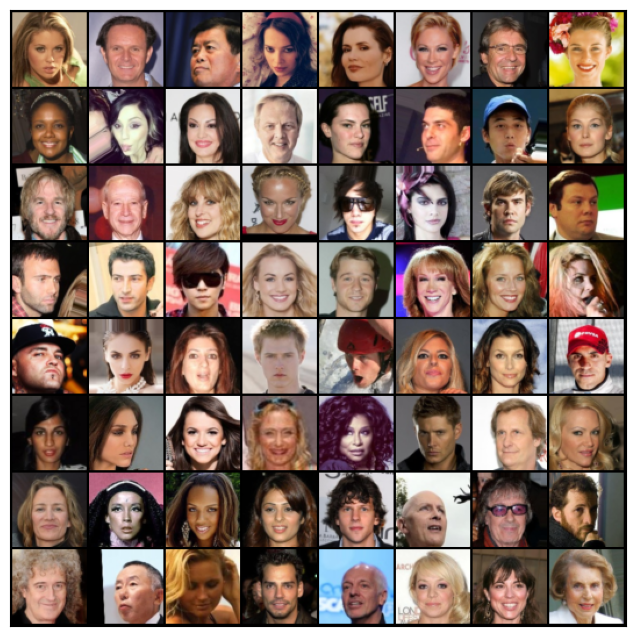

In [6]:
# %%
image_size = 64
batch = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# %%
train_ds = ImageFolder(root=DATA_DIR, 
                       transform=T.Compose([T.Resize(image_size), T.CenterCrop(image_size), T.ToTensor(), T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch, shuffle=True, num_workers=3, pin_memory=True) # use multiple cores

# %%
def denorm(img_tensors):
    "Denormalize image tensor with specified mean and std"
    return img_tensors * stats[1][0] + stats[0][0]

# %%
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
  
def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

# %%
show_batch(train_dl)



In [7]:
# %%
# ensure use of GPU if available, else use CPU - needs correct CUDA installed
def get_default_device():
    """Pick GPU if available, else CPU"""
    """ 3 things:
    1. Connected to Nvidia GPU
    2. Cuda drivers
    3. Pytorch suitable to GPU version
    then torch.cuda.is_available is True
    """
    if torch.cuda.is_available():
        print("GPU")
        return torch.device('cuda')
    else:
        print("CPU")
        return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
      return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Num of batches"""
        return len(self.dl)

# %%
device = get_default_device()

# %%
train_dl = DeviceDataLoader(train_dl, device)




GPU


Conv2d output shape: 	 torch.Size([1, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 64, 32, 32])
LeakyReLU output shape: 	 torch.Size([1, 64, 32, 32])
Conv2d output shape: 	 torch.Size([1, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 128, 16, 16])
LeakyReLU output shape: 	 torch.Size([1, 128, 16, 16])
Conv2d output shape: 	 torch.Size([1, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([1, 256, 8, 8])
LeakyReLU output shape: 	 torch.Size([1, 256, 8, 8])
Conv2d output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([1, 512, 4, 4])
LeakyReLU output shape: 	 torch.Size([1, 512, 4, 4])
Conv2d output shape: 	 torch.Size([1, 1, 1, 1])
Flatten output shape: 	 torch.Size([1, 1])
Sigmoid output shape: 	 torch.Size([1, 1])
ConvTranspose2d output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([1, 512, 4, 4])
ReLU output shape: 	 torch.Size([1, 512, 4, 4])
ConvTranspose2d output shape: 	 torch.Size([1, 256, 8, 8])
Batc

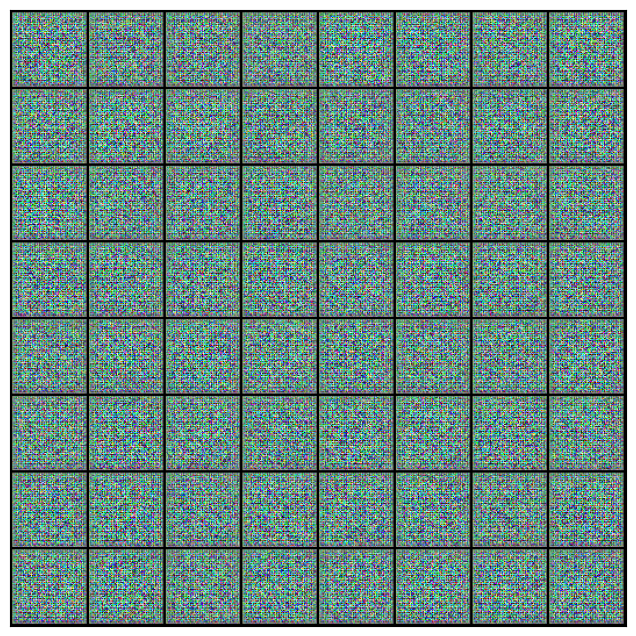

In [8]:
# %%
# in: 3x 64 x 64
dis = nn.Sequential(
    # out: 64 x 32 x 32
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    # out: 128 x 16 x 16
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    # out: 256 x 8 x 8
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    # out: 512 x 4 x 4
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    # out: 1 x 1 x 1
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()
)

# %%
dis = to_device(dis, device)

# %%
X = torch.rand(size=(1, 3, 64, 64), dtype=torch.float32, device=device) 
for layer in dis:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# %%
latent_size = 128

# %%
# in: latent_size x 1 x 1
gen = nn.Sequential(

    # out: 512 x 4 x 4
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    # out: 256 x 8 x 8
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    # out: 128 x 16 x 16
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    # out: 64 x 32 x 32
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    # out: 3 x 64 x 64
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # output is between -1 to 1
)

# %%
X = torch.randn(size=(1, 128, 1, 1))
for layer in gen:
  X = layer(X)
  print(layer.__class__.__name__,'output shape: \t',X.shape)

# %%
xb = torch.randn(batch, latent_size, 1, 1)
fakes = gen(xb)
print(fakes.shape)
show_images(fakes)

# %%
gen = to_device(gen, device)

# %%
def train_discriminator(real_images, opt_d):
  opt_d.zero_grad()

  # pass real images to the dis
  real_preds = dis(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # gen fakes
  latent = torch.randn(batch, latent_size, 1, 1, device=device)
  fake_images = gen(latent)

  # pass the fakes to the dis
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = dis(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # update dis weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

# %%
def train_generator(opt_g):
  opt_g.zero_grad()

  # gen fake images
  latent = torch.randn(batch, latent_size, 1,1, device=device)
  fake_images = gen(latent)

  # try fool the discriminator
  preds = dis(fake_images)
  targets = torch.ones(batch, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  # update gen weights
  loss.backward()
  opt_g.step()

  return loss.item()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated=images-0000.png


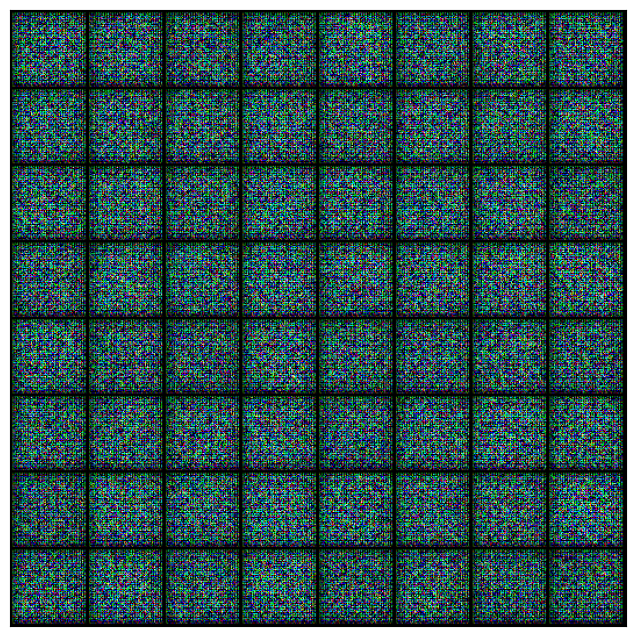

In [9]:
# %%
from torchvision.utils import save_image

# %%
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

# %%
def save_samples(index, latent_tensors, show=True):
  fake_images = gen(latent_tensors)
  fake_fname = 'generated=images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print("Saving", fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

# %%
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

# %%
save_samples(0, fixed_latent)

# %%
from tqdm.notebook import tqdm
import torch.nn.functional as F

# %%
def fit(epochs, lr, start_idx = 1):
  torch.cuda.empty_cache()

  opt_d = torch.optim.Adam(dis.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      train_discriminator(real_images, opt_d)
      train_generator(opt_g)
    save_samples(epoch+start_idx, fixed_latent, show=False)


# %%
lr = 0.00025
epochCount = 60



In [13]:
history = fit(epochCount, lr)

  0%|          | 0/782 [00:00<?, ?it/s]

Saving generated=images-0001.png


  0%|          | 0/782 [00:00<?, ?it/s]

Saving generated=images-0002.png


  0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

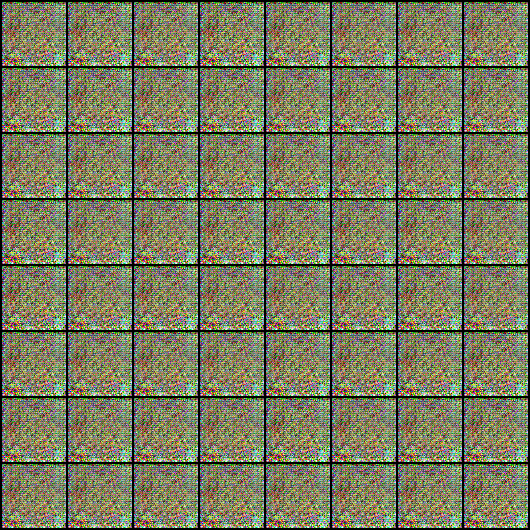

In [11]:
# %%
torch.save(gen.state_dict(), 'G.pth')
torch.save(dis.state_dict(), 'D.pth')

# %%
from IPython.core.display import Image

# %%
Image('./generated/generated=images-0001.png')